In [ ]:
import sklearn
import matplotlib.pyplot
import pandas
import torch
import requests
#-------------------------------------#
from pathlib import Path
#-------------------------------------#
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
#-------------------------------------#
from torch import nn
#-------------------------------------#
from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
# Dataset
n_samples = 1000

x,y = make_circles(n_samples,noise=0.03,random_state=42)

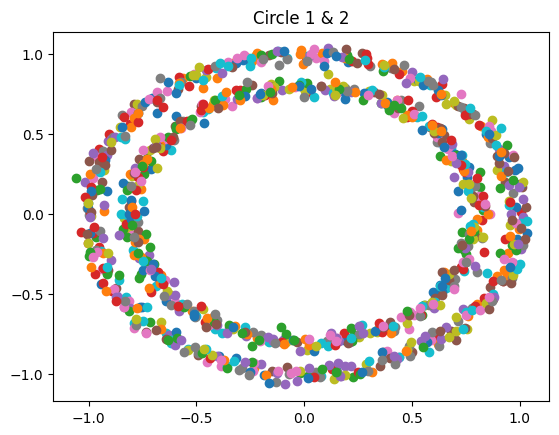

In [ ]:
# Visualize the dataset
for i in range(0,1000):
  matplotlib.pyplot.plot(x[i][0],x[i][1],'o')

matplotlib.pyplot.title("Circle 1 & 2")
matplotlib.pyplot.show()

In [ ]:
# Make dataframe of circle data
circles = pandas.DataFrame({"X1":x[:,0],
                           "X2":x[:,1],
                           "label":y})
circles.sample(5)

,X1,X2,label
614,-0.784825,0.289742,1
254,0.217986,-0.951466,0
685,0.928248,0.382374,0
258,0.478732,-0.685719,1
143,-0.972176,-0.377560,0


In [ ]:
# Align input and output shapes
x.shape,y.shape

((1000, 2), (1000,))

In [ ]:
# Data type of each variable
type(x),type(y)

(numpy.ndarray, numpy.ndarray)

In [ ]:
# Convert numpy arrays into tensors 
X = torch.from_numpy(x).type(torch.float)
Y = torch.from_numpy(y).type(torch.float)
X.dtype,Y.dtype

(torch.float32, torch.float32)

In [ ]:
# create train and test splits
X_train,X_test, Y_train, Y_test = train_test_split(X
                                                   ,Y
                                                   ,test_size=0.2
                                                   ,random_state=None)
X_train.dtype,X_test.dtype,Y_train.dtype,Y_test.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

In [ ]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [ ]:
# Designing Model
## Constructing a model that subcleasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    ### create nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)
  ### forward method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x))

### Instantiate an instance of our model
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
## Desiging a model with nn.Sequential

model_1 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Predictions with untrained model
with torch.inference_mode():
  untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)},Shapes: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)},Shape: {X_test.shape}")
print(f"\nFirsst 10 Predictions: \n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 Labels \n{Y_test[:10]}")

Length of predictions: 200,Shapes: torch.Size([200, 1])
Length of test samples: 200,Shape: torch.Size([200, 2])

Firsst 10 Predictions: 
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.]])

First 10 Labels 
tensor([0., 0., 1., 1., 0., 0., 0., 1., 1., 0.])


In [ ]:
 ## Set up loss function and optimzer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
## Calculate the accuracy
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
## Train model
epochs = 100

for epoch in range(epochs):
  ## training
  model_0.train()

  ## foraward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss/accuracy
  loss = loss_fn(y_logits
                ,Y_train)
  
  acc = accuracy_fn(y_true=Y_train
                    ,y_pred=y_pred)
  # optimizer with zero grad
  optimizer.zero_grad()
  # loss backward propagation
  loss.backward()
  # optimizer (gradient descent)
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate loss
    test_loss = loss_fn(test_logits
                        ,Y_test)
    
    test_acc = accuracy_fn(y_true=Y_test
                           ,y_pred=test_pred)
  if epoch % 10 ==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.5f} | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71511, Acc: 51.00000 | Test Loss: 0.72968, Test acc: 46.00%
Epoch: 10 | Loss: 0.70424, Acc: 57.75000 | Test Loss: 0.71281, Test acc: 55.00%
Epoch: 20 | Loss: 0.70028, Acc: 53.25000 | Test Loss: 0.70555, Test acc: 55.00%
Epoch: 30 | Loss: 0.69846, Acc: 52.50000 | Test Loss: 0.70204, Test acc: 53.00%
Epoch: 40 | Loss: 0.69739, Acc: 51.75000 | Test Loss: 0.70018, Test acc: 51.50%
Epoch: 50 | Loss: 0.69662, Acc: 51.62500 | Test Loss: 0.69911, Test acc: 52.00%
Epoch: 60 | Loss: 0.69601, Acc: 51.75000 | Test Loss: 0.69846, Test acc: 52.00%
Epoch: 70 | Loss: 0.69552, Acc: 51.75000 | Test Loss: 0.69804, Test acc: 52.50%
Epoch: 80 | Loss: 0.69510, Acc: 52.00000 | Test Loss: 0.69777, Test acc: 53.00%
Epoch: 90 | Loss: 0.69475, Acc: 51.75000 | Test Loss: 0.69758, Test acc: 53.50%


In [ ]:
if Path("helper_functions.py").is_file():
  print("helper functions file exsists")
else:
  print("Downloading helper functions")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

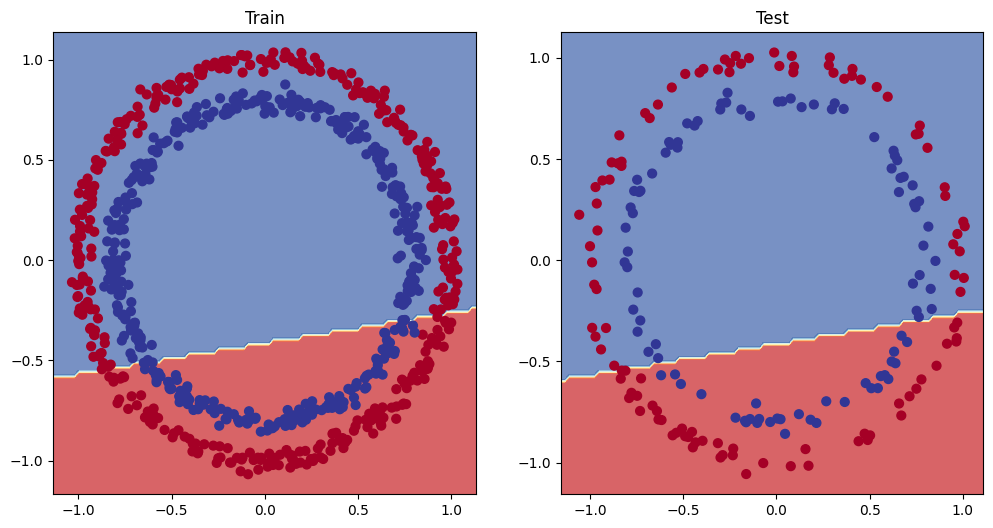

In [ ]:
# Plot decision boundary of the model
matplotlib.pyplot.figure(figsize=(12,6))
matplotlib.pyplot.subplot(1,2,1)
matplotlib.pyplot.title("Train")
plot_decision_boundary(model_0,X_train,Y_train)
matplotlib.pyplot.subplot(1,2,2)
matplotlib.pyplot.title("Test")
plot_decision_boundary(model_0,X_test,Y_test)

In [ ]:
# improve the model
